In [17]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import sys

sys.path.append('/Users/rgao/Documents/Code/research/neurodsp/')
from neurodsp import spectral

### white and colored noise simulation
Here, we simulate white and colored noise (plus oscillation) and compute the spectral CV to see if they are indeed equal to 1.

In [18]:
fs = 1000.
t = np.arange(0.,600.,1./fs)
ker = np.exp(-50*np.arange(0,500)/1000.)

# oscillation
oFreq = 20.22
oAmp = 0.5
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*oAmp

# initialize array
numtrs = 50
SCVnoise = np.zeros((numtrs,501,3))
for tr in range(0,numtrs):
    # run through trials
    print tr,
    # white noise
    x = np.random.normal(size=(len(t)))
    f, SCV = spectral.scv(x, fs, noverlap=0)
    SCVnoise[tr,:,0] = SCV
    
    # colored noise
    y = np.convolve(x,ker,mode='same')
    f, SCV = spectral.scv(y, fs, noverlap=0)
    SCVnoise[tr,:,1] = SCV    
    
    #colored noise plus oscillation
    f, SCV = spectral.scv(y+osc, fs, noverlap=0)
    SCVnoise[tr,:,2] = SCV    


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


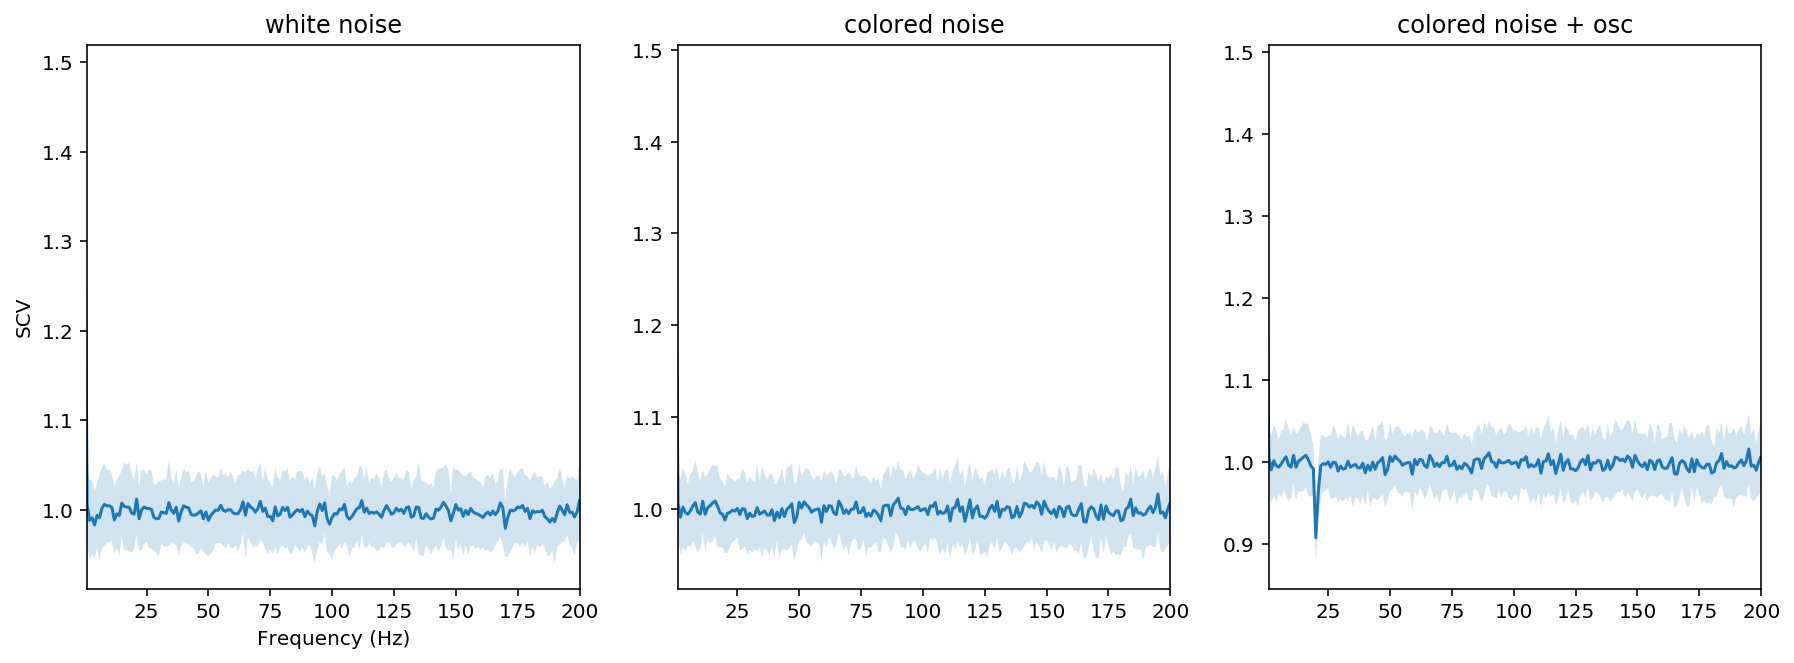

In [19]:
mSCV = np.squeeze(np.mean(SCVnoise,axis=0))
sSCV = np.squeeze(np.std(SCVnoise,axis=0))
plt.figure(figsize=(15,5))
labels = ('white noise', 'colored noise', 'colored noise + osc')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.fill_between(f,mSCV[:,i]-sSCV[:,i], mSCV[:,i]+sSCV[:,i], alpha=0.2)
    plt.plot(mSCV[:,i])
    plt.xlim((1,200))
    plt.title(labels[i])
    
plt.subplot(1,3,1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')


### colored noise and oscillation demonstration
Just to visualize the scale of the oscillation compared to the noise process.

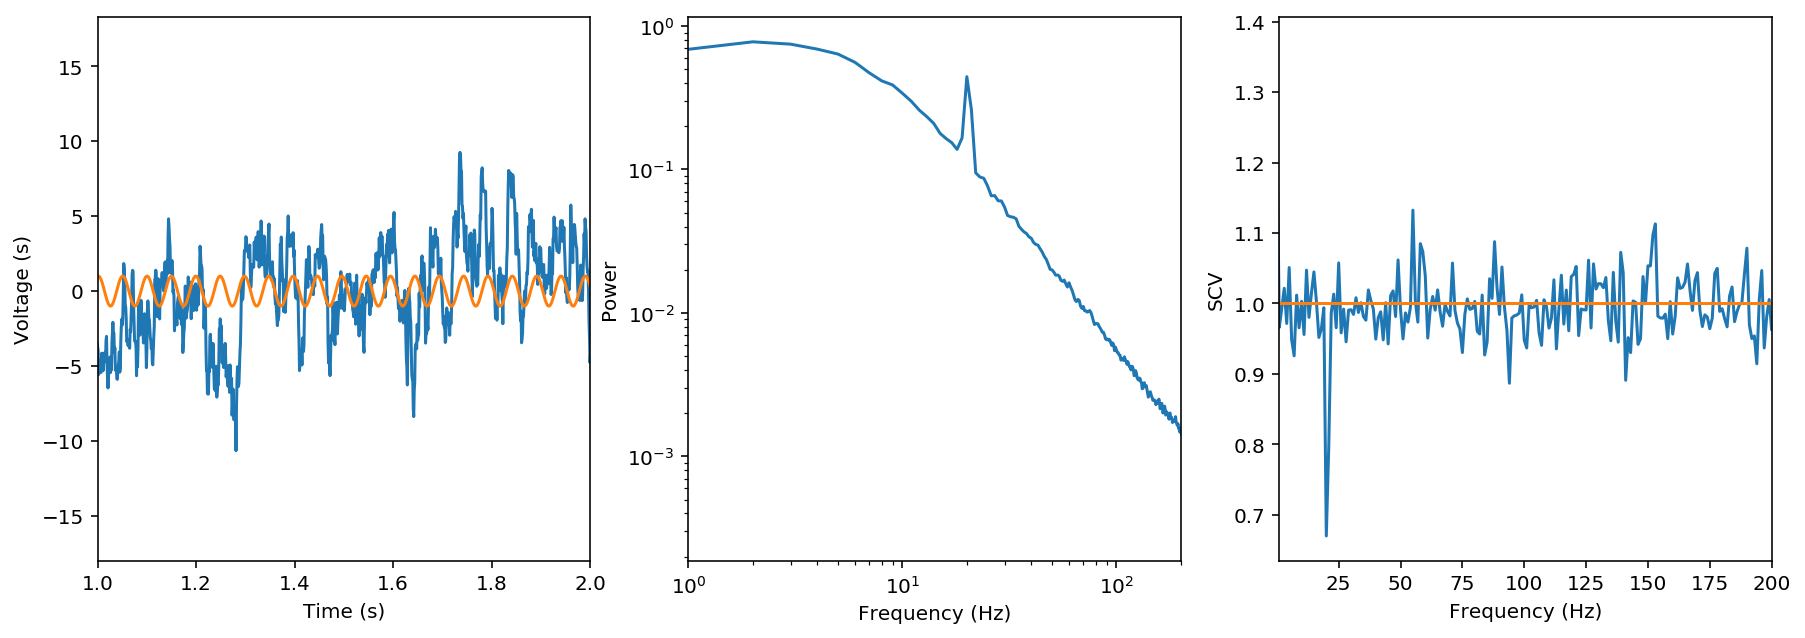

In [21]:
oFreq = 20.22
oAmp = 1.
fs = 1000.
t = np.arange(0.,600.,1./fs)
x = np.random.normal(size=(len(t)))
ker = np.exp(-50*np.arange(0,500)/1000.)
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*oAmp
y = np.convolve(x,ker,mode='same')+osc
f, PSD = spectral.psd(y, fs)
f, SCV = spectral.scv(y, fs, noverlap=0)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,y)
plt.plot(t,osc)
plt.xlim((1,2))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (s)')

plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((0,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')

### Resampled calculation of SCV for colored noise

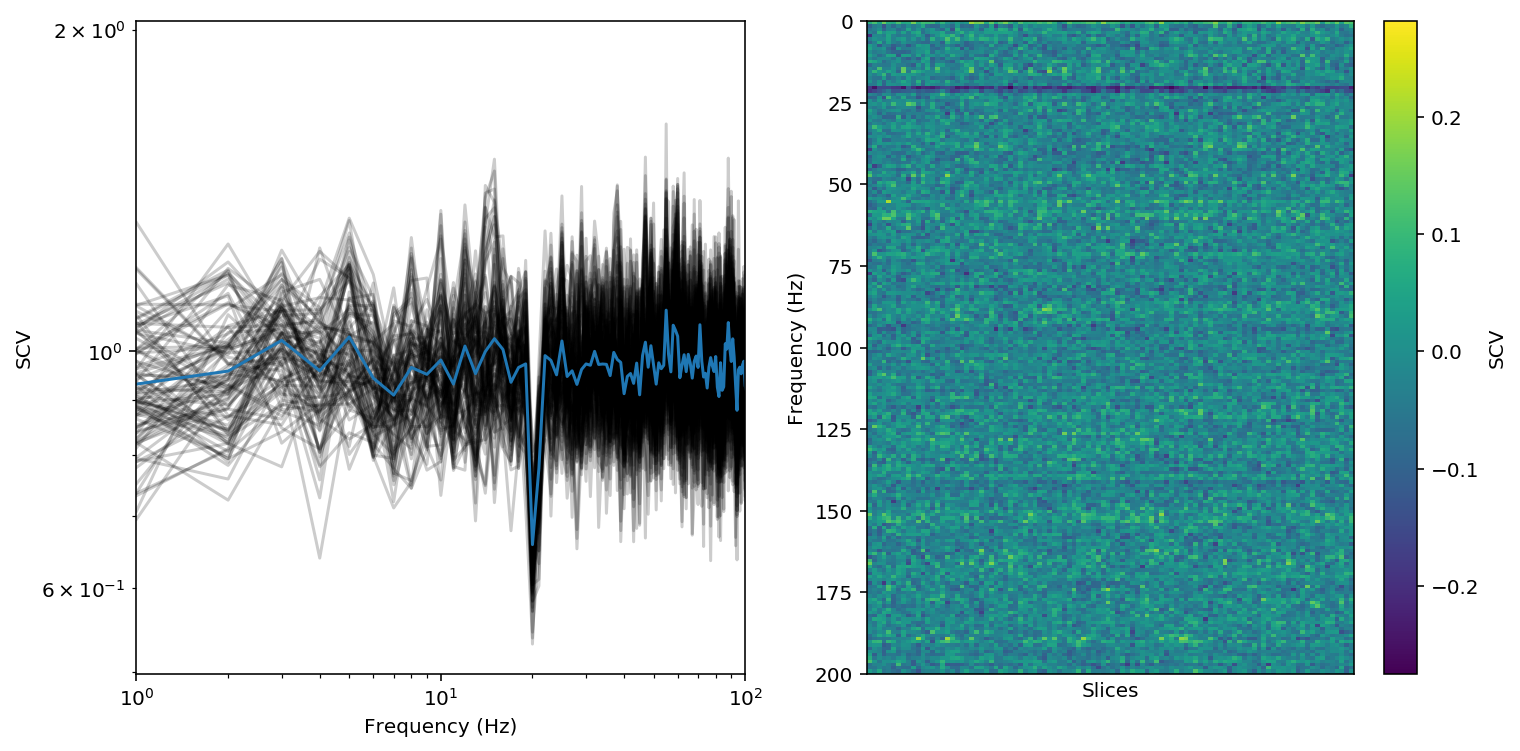

In [25]:
f, T, SCVrs = spectral.scv_rs(y, fs, method='bootstrap')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.loglog(f, SCVrs, 'k', alpha=0.2);
plt.loglog(f, np.mean(SCVrs,axis=1));
plt.xlim((1,100))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')

plt.subplot(1,2,2)
plt.imshow(np.log10(SCVrs), aspect='auto', extent=(0,1,f[-1],f[0]))
plt.colorbar(label='SCV')
plt.ylim((200,0))
plt.xticks([])
plt.xlabel('Slices')
plt.ylabel('Frequency (Hz)')

### Ornstein-Uhlenbeck process
OU process has a longer memory than the smoothed white noise, acheiving "true" colored noise.

Simulating a discrete-time OU process:
https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab


In [37]:
th = 1. # memory scale (higher = faster fluc)
mu = 0. # mean
sig = 5. # std
fs = 1000.
dt = 1./fs
t = np.arange(0.,600.,1./fs)
rand = np.random.normal(size=len(t))
x0 = 0.
ex = np.exp(-th*t);
rand[0]=0.
x = x0*ex+mu*(1.-ex)+sig*ex*np.cumsum(np.exp(th*t)*np.sqrt(dt)*rand) + osc

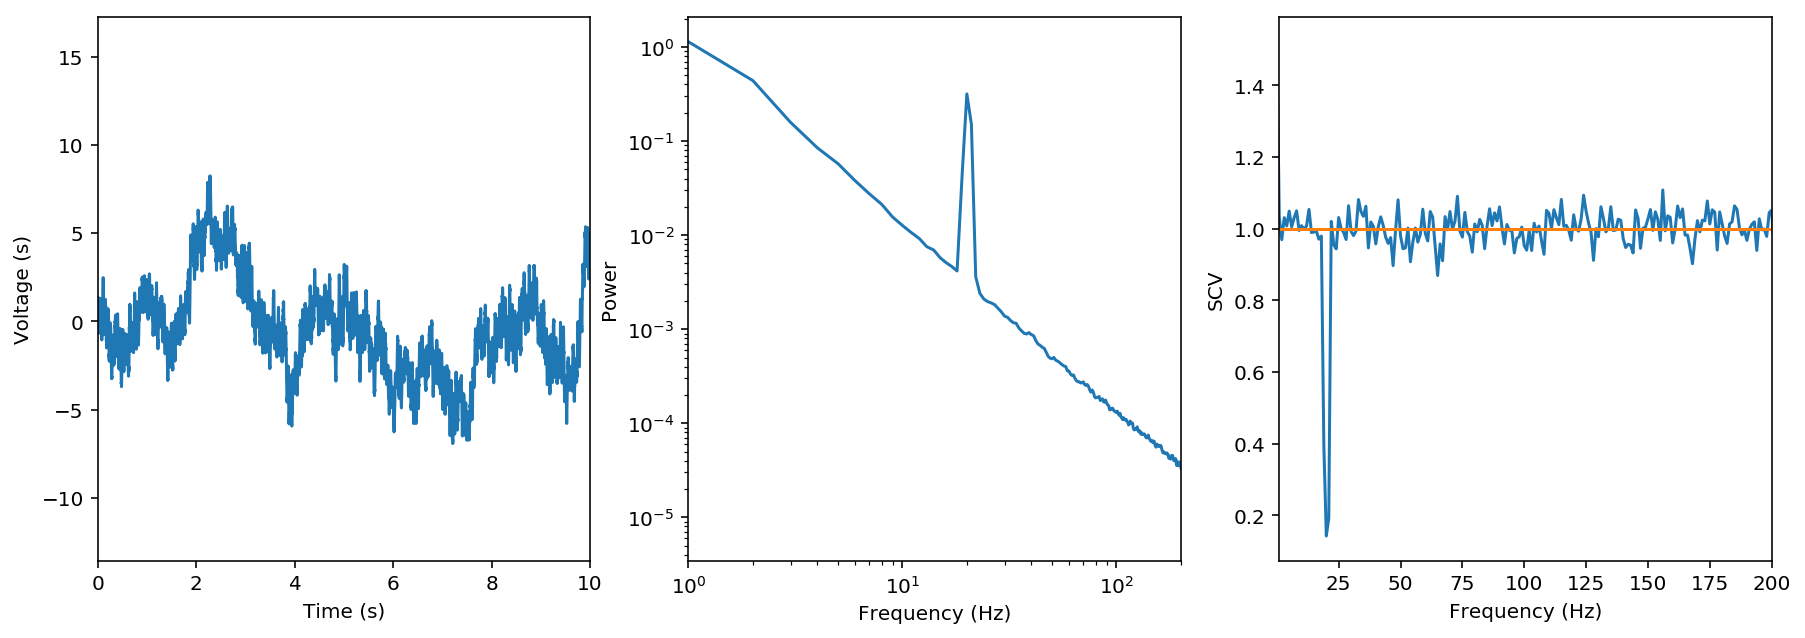

In [38]:
f, PSD = spectral.psd(x, fs)
f, SCV = spectral.scv(x, fs, noverlap=0)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,x, alpha=1.)
plt.xlim((0,10.))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (s)')

plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((0,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')